In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm, ecdf
from scipy.stats import uniform
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ДЗ-2 по Теории и практике онлайн экспериментов

### Задание 1 (1.5 балла)

В приложенном файле `sleep.csv` приведено время засыпания одного и того же человека в разные дни.

Нужно обработать эти данные и указать такое время суток (с точностью до минуты), после которого с вероятностью 0.9 этот человек уже спит.

Как можно оценить стандартное отклонение этой точечной оценки?

**Ответ**. Вероятность найдем по данным: просто посмотрим на 90% квантиль столбца time_offset, где indicator = 1 (то есть человек уже спит). Стандартное отклонение же оценим с помощью бутстрапа, причем выборки будем генерировать размера наших данных, где человек спит, чтобы оценка была несмещенной.

In [ ]:
sleep = pd.read_csv('/content/drive/MyDrive/tpoe/sleep.csv')
sleep.head()

,Unnamed: 0,indicator,time_offset
0,2017-12-01 21:00:00,0,-60
1,2017-12-01 21:01:00,0,-59
2,2017-12-01 21:02:00,0,-58
3,2017-12-01 21:03:00,0,-57
4,2017-12-01 21:04:00,0,-56


In [ ]:
sleep[sleep.time_offset >= -2]

,Unnamed: 0,indicator,time_offset
58,2017-12-01 21:58:00,0,-2
59,2017-12-01 21:59:00,0,-1
60,2017-12-01 22:00:00,0,0
61,2017-12-01 22:01:00,0,1
62,2017-12-01 22:02:00,0,2
...,...,...,...
11335,2018-02-01 23:55:00,1,115
11336,2018-02-01 23:56:00,1,116
11337,2018-02-01 23:57:00,1,117
11338,2018-02-01 23:58:00,1,118


Отлично, человек всегда засыпает до 23:59 включительно! Это упрощает задачу, ведь нам не надо думать о том, что засыпание в 0:05 --- это засыпание позже, чем в 23:59, хотя по величине 0:05 меньше.

In [ ]:
time_passed = sleep[sleep.indicator == 1].time_offset
size_passed = len(time_passed)
prob = time_passed.quantile(0.9)
time_prob = sleep[sleep.time_offset == prob].iloc[0]['Unnamed: 0'].split()[1][:-3]

size_subsample = 1000
bootstrap_quantiles = []
for _ in range(size_subsample):
  bootstrap_values = np.random.choice(time_passed, size_passed, True)
  bootstrap_quantiles.append(np.quantile(bootstrap_values, 0.9))

std = np.std(bootstrap_quantiles)
print(f'Время, после которого человек спит с вероятностью 90%: {time_prob}')
print(f'Оценка std для 90% вероятности: {std:0.2f}')

Время, после которого человек спит с вероятностью 90%: 23:49
Оценка std для 90% вероятности: 0.45


-----------
Представим, что у нас есть сервис для продажи некоторых товаров (например, мыла). Мы выкатываем новые фичи и проводим тесты, а затем сохраняем логи каждого теста в следующем формате:

- `user_id` - уникальный id посетителя сайта
- `dt` - дата события
- `event` - название события
- `group` - группа, в которую попал пользователь (распределение может происходить на разных этапах воронки для разных тестов - например, при первом посещении или при первом добавлении в корзину)
- `visit_id` - уникальный id визита
- `cart_id` - уникальный id корзины
- amount - текущая сумма корзины
- `num_items` - текущее количество товаров в корзине

### Задание 2 (0.5 балла)

Мы сделали рекомендательную систему, которая после добавления товара в корзину предлагает добавить похожие или комплементарные. Логи проведенного теста сохранены в файле `ab_test_logs.pkl`. Проверьте гипотезу о том, что в тестовой группе для 70% пользователей выросла выручка (revenue per user).

In [ ]:
ab_test_logs = pd.read_pickle('/content/drive/MyDrive/tpoe/ab_test_logs.pkl')
ab_test_logs.head()

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,3Y6FR5,2024-01-17,first-visited,NaN,NaN,NaN,NaN,NaN
1,6W79RT,2024-01-17,first-visited,NaN,NaN,NaN,NaN,NaN
2,6W79RT,2024-01-17,registered,test,NaN,NaN,NaN,NaN
3,6W79RT,2024-01-17,shop-visit,test,3qzhu3sar2vee6rzssyr,NaN,NaN,NaN
4,6W79RT,2024-01-18,shop-visit,test,siglppuqke79ts5a5r4t,NaN,NaN,NaN


Проверим наши данные, нет ли у нас пользователей, которые в рамках одного теста были отнесены к разным группам:

In [ ]:
wrong_users = set(ab_test_logs[ab_test_logs.group == 'test'].user_id) & set(ab_test_logs[ab_test_logs.group == 'control'].user_id)
len(wrong_users)

301

Сделаем бонус из объявлений:
>Может быть такое, что чел принадлежит к разным группам. Что с этим делать:
2) Ручками заассайнить челов в нужную группу по доле событий, которых у него больше (из теста или контроля) - за этот вариант +0.5 баллов дадим, если все верно

In [ ]:
# тут есть момент: где были только NaN, мы считаем теперь за control, исправим ниже

pivot_table = ab_test_logs.pivot_table(index='user_id', columns='group', aggfunc='size', fill_value=0)
pivot_table['true_group'] = pivot_table.apply(lambda row: 'control' if row['control'] >= row['test'] else 'test', axis=1)
pivot_table = pivot_table[['true_group']]
pivot_table.head()

group,true_group
user_id,
009CU2,control
009TG0,test
00OXAP,control
015V6Y,control
01LPK6,control


In [ ]:
# где были NaN, NaN и оставим, а где не было - присвоим нужное значение

ab_test_logs_true = pd.merge(ab_test_logs, pivot_table, on='user_id')
ab_test_logs_true['group'] = np.where(pd.isnull(ab_test_logs_true['group']), np.nan, ab_test_logs_true['true_group'])
del ab_test_logs_true['true_group']

In [ ]:
ab_test_logs_true

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,6W79RT,2024-01-17,first-visited,NaN,NaN,NaN,NaN,NaN
1,6W79RT,2024-01-17,registered,test,NaN,NaN,NaN,NaN
2,6W79RT,2024-01-17,shop-visit,test,3qzhu3sar2vee6rzssyr,NaN,NaN,NaN
3,6W79RT,2024-01-18,shop-visit,test,siglppuqke79ts5a5r4t,NaN,NaN,NaN
4,6W79RT,2024-01-20,shop-visit,test,9yeltfgv3e5t5zzz2m14,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
48432,PZPDW4,2024-01-24,shop-visit,test,8f2utmlfa8ulynppb2kz,NaN,NaN,NaN
48433,XI8SXP,2024-01-15,first-visited,NaN,NaN,NaN,NaN,NaN
48434,XI8SXP,2024-01-23,registered,test,NaN,NaN,NaN,NaN
48435,OWZKP8,2024-01-23,first-visited,NaN,NaN,NaN,NaN,NaN


In [ ]:
# убедимся, что исправили

wrong_users = set(ab_test_logs_true[ab_test_logs_true.group == 'test'].user_id) & set(ab_test_logs_true[ab_test_logs_true.group == 'control'].user_id)
len(wrong_users)

0

Посмотрим значения некоторых нужных нам столбцов:

In [ ]:
ab_test_logs_true.group.unique()

array([nan, 'test', 'control'], dtype=object)

In [ ]:
ab_test_logs_true.event.unique()

array(['first-visited', 'registered', 'shop-visit', 'cart-add',
       'cart-paid'], dtype=object)

Получается, у нас нет опции удалить из корзины и итоговая цена покупки лежит в последнем cart-add перед покупкой, т.к. на действии cart-paid корзина уже обнулена.

In [ ]:
# проверяем, что в amount уже ничего не лежит, когда корзина оплачена

pays = ab_test_logs_true[ab_test_logs_true.event == 'cart-paid']
pays.amount.dropna()

Series([], Name: amount, dtype: float64)

Дальше я чуть не умир!!!!!!!!!!!!!!!!!!!! пытаясь собрать данные, но в итоге все выглядит легко:

In [ ]:
# добавляю столбец is_paid: оплачена ли корзина (у каждой корзины свой id и корзина может окончиться покупкой или нет)
is_paid = ab_test_logs_true.groupby('cart_id')['event'].apply(lambda x: 'cart-paid' in x.values)
data_ispaid = pd.merge(ab_test_logs_true, is_paid.rename('is_paid'), on='cart_id')

# теперь делаю так, чтобы в столбце amount была записана итоговая корзина (то есть последнее обновление)
receipts = data_ispaid.loc[data_ispaid.groupby('cart_id')['amount'].idxmax()]

# если корзина не оплачена, присваиваем сумме покупки 0
receipts['amount'] = receipts['amount'] * receipts['is_paid']

# суммирую все покупки для пользователя
users_revenue = receipts.groupby('user_id').agg({'amount': 'sum', 'group': 'last'})
users_revenue

,amount,group
user_id,,
01ZW0R,5853.584375,test
02CQJP,1001.403828,control
02QS9O,177.672692,control
03A9GD,8808.518074,test
04RYQW,9910.717453,test
...,...,...
ZXS8UT,301.766633,test
ZXX9UM,1727.314208,control
ZZ55D1,265.327179,test


Наконец, сравним выручки. Нам нужно проверить, что для 70% пользователей выросла выручка. Проверим гипотезу с помощью бутстрепа!

>Чтобы проверить гипотезу о равенстве квантилей на уровне значимости 5% достаточно построить 95% доверительный интервал для разности квантилей между группами.
Если ноль находится вне доверительного интервала, то отличия статистически значимы, иначе нет.

In [ ]:
def get_percentile_ci(bootstrap_stats, alpha):
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

In [ ]:
alpha = 0.05
size_subsample = 10000

control_revenue = users_revenue[users_revenue.group == 'control'].amount
test_revenue = users_revenue[users_revenue.group == 'test'].amount
size_control = len(control_revenue)
size_test = len(test_revenue)

pe = np.quantile(test_revenue, 0.7) - np.quantile(control_revenue, 0.7)
pe_rel = np.quantile(test_revenue, 0.7)/np.quantile(control_revenue, 0.7) * 100 - 100

bootstrap_values_control = np.random.choice(control_revenue, (size_subsample, size_control), True)
bootstrap_metrics_control = np.quantile(bootstrap_values_control, 0.7, axis=1)

bootstrap_values_test = np.random.choice(test_revenue, (size_subsample, size_test), True)
bootstrap_metrics_test = np.quantile(bootstrap_values_test, 0.7, axis=1)

bootstrap_stats = bootstrap_metrics_test - bootstrap_metrics_control
ci = get_percentile_ci(bootstrap_stats, alpha)
has_effect = not (ci[0] < 0 < ci[1])

print(f'Значение 70% квантиля изменилось на: {pe:0.2f} - или в процентах: {pe_rel:0.2f}%')
print(f'{((1 - alpha) * 100)}% доверительный интервал: ({ci[0]:0.2f}, {ci[1]:0.2f})')
print(f'Отличия статистически значимые: {has_effect}')

Значение 70% квантиля изменилось на: 33.23 - или в процентах: 1.67%
95.0% доверительный интервал: (-258.70, 334.80)
Отличия статистически значимые: False


### Задание 3 (1 балл)

Как проверить гипотезу о том, что средний чек в А и Б группе разный? Реализуйте этот алгоритм. Помните, что у одного пользователя может быть много чеков.

**Ответ**. Т.к. у одного пользователя может быть много чеков, данные становятся зависимыми и t-тест не подходит. Поэтому будем использовать дельта-метод.

Подготовим данные. В прошлом задании мы получили массив ```receipts```, в котором храним информацию по каждому чеку. Оставим только те строки, где заказ оплачен:

In [ ]:
receipts = receipts[receipts.is_paid == True]
receipts.head()

,user_id,dt,event,group,visit_id,cart_id,amount,num_items,is_paid
3547,K9R4LH,2024-01-17,cart-add,test,48uem3lbhkru22gqnv34,00ex0m9cnj,1485.659248,1.0,True
5037,BXWDSY,2024-01-13,cart-add,test,3760xzjr0ed0hoggedns,00nr9mvpz3,2034.952469,4.0,True
4221,ILT2OU,2024-01-19,cart-add,control,5f40oexpy5chebl7u01a,00ro134yeb,683.136858,1.0,True
518,FXWSF5,2024-01-18,cart-add,test,0xa9mhdilemvjfupvbvi,00w9rth33r,2371.104744,2.0,True
1018,ED6MXB,2024-01-18,cart-add,test,xgtxduxyjsw9gtp5b5qp,01bcydue0s,3854.632102,3.0,True


In [ ]:
control_receipts = receipts[receipts.group == 'control'].groupby('user_id').agg(purchases=('cart_id', 'count'),
                                                                                total_amount=('amount', 'sum'))
test_receipts = receipts[receipts.group == 'test'].groupby('user_id').agg(purchases=('cart_id', 'count'),
                                                                                total_amount=('amount', 'sum'))

control_receipts

,purchases,total_amount
user_id,,
02CQJP,1,1001.403828
02QS9O,1,177.672692
05TM9T,1,329.382022
07KF3X,3,6168.448617
081JAT,1,1261.589807
...,...,...
ZJPIGR,1,442.793129
ZJT2QZ,1,658.482766
ZMBV83,1,3879.990060


Адаптируем под нас код с семинара:

In [ ]:
def check_delta_method(a, b):
    dict_ = {}
    for data, group_name in [(a, 'a',), (b, 'b',)]:
        n_user = len(data)

        array_x = np.array(data.total_amount)
        array_y = np.array(data.purchases)

        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        var_x, var_y = np.var(array_x), np.var(array_y)
        cov_xy = np.cov(array_x, array_y)[0, 1]

        # точечная оценка метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x/ mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_user

        dict_[f'pe_metric_{group_name}'] = pe_metric
        dict_[f'var_metric_{group_name}'] = var_metric

    var = dict_['var_metric_a'] + dict_['var_metric_b']
    delta = dict_['pe_metric_b'] - dict_['pe_metric_a']

    t = delta / np.sqrt(var)
    pvalue = (1 - norm.cdf(np.abs(t))) * 2

    return pvalue, dict_['pe_metric_a'], dict_['pe_metric_b']

Сделаем две вещи: 1) проверим, что наш код работает корректно, для этого проведем А/А-тест: сгенерируем обе подвыборки из одной группы и посмотрим, что pvalue распределен равномерно, 2) проверим непосредственно гипотезу, что средние чеки в группах А и Б разные.

In [ ]:
def plot_pvalue_distribution(dict_pvalues):
    """Рисует графики распределения p-value."""
    X = np.linspace(0, 1, 1000)
    for name, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, label=name)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

In [ ]:
alpha = 0.05

pvalues_aa = []
pvalues_ab = []
for _ in range(1000):
    a, b = control_receipts.sample(n=100, replace=True), control_receipts.sample(n=100, replace=True)
    pvalues_aa.append(check_delta_method(a, b)[0])

    a, b = control_receipts.sample(n=100, replace=True), test_receipts.sample(n=100, replace=True)
    pvalues_ab.append(check_delta_method(a, b)[0])

error_rate_AA = np.mean(np.array(pvalues_aa) < alpha)
print(f'Доля ошибок первого рода в А/А-тесте: {error_rate_AA:0.2f}')
error_rate_AB = np.mean(np.array(pvalues_ab) < alpha)
print(f'Доля ошибок первого рода в А/B-тесте: {error_rate_AB:0.2f}')

Доля ошибок первого рода в А/А-тесте: 0.03
Доля ошибок первого рода в А/B-тесте: 0.04


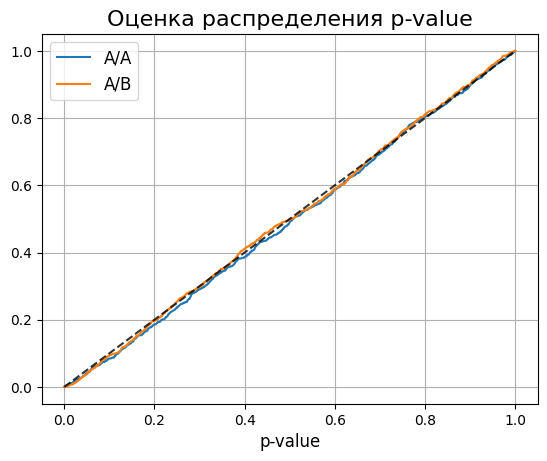

In [ ]:
plot_pvalue_distribution({'A/A': pvalues_aa, 'A/B': pvalues_ab})

In [ ]:
check_delta_method(control_receipts, test_receipts)

(0.31611559597015737, 2017.2937086960237, 2177.3438502564186)

pvalue говорит, что разница не статзначима. На графике мы тоже видим, что pvalue распределено равномерно, то есть группы очень похожи. Мы так же видим, что отношение подросло совсем чуть-чуть: меньше 1%. Считаем, что средний чек в группах похожий.

### Задание 4 (1 балл)

Мы заменили все фотографии мыла на сайте более привлекательными снимками от профессионального фотографа и отфотошопили их. Результаты теста в файле `ctr_test_logs.pkl`. Как такое изменение повлияло на конверсию из визита в добавление в корзину? Проведите соответствующий тест и не забудьте о том, что имеете дело с метрикой отношения.

**P.s. в этом задании решение методом бутстрапа не будет засчитываться**

In [ ]:
ctr_test_logs = pd.read_pickle('/content/drive/MyDrive/tpoe/ctr_test_logs.pkl')
ctr_test_logs.head()

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,Q9IK2A,2024-02-25,first-visited,NaN,NaN,NaN,NaN,NaN
1,Q9IK2A,2024-02-25,registered,b,NaN,NaN,NaN,NaN
2,Q9IK2A,2024-02-26,shop-visit,b,k4yi0jd4clxduvmsk04g,NaN,NaN,NaN
3,XVXL0K,2024-02-13,first-visited,NaN,NaN,NaN,NaN,NaN
4,XVXL0K,2024-02-14,shop-visit,a,sp3hls8m82xwudv1qgms,NaN,NaN,NaN


In [ ]:
# опять несколько пользователей определены в обе группы

len(set(ctr_test_logs[ctr_test_logs.group=='a'].user_id)&set(ctr_test_logs[ctr_test_logs.group=='b'].user_id))

71

In [ ]:
pivot_table_group = ctr_test_logs.pivot_table(index='user_id', columns='group', aggfunc='size', fill_value=0)
pivot_table_group['true_group'] = pivot_table_group.apply(lambda row: 'a' if row['a'] >= row['b'] else 'b', axis=1)
pivot_table_group = pivot_table_group[['true_group']]
pivot_table_group.head()

group,true_group
user_id,
00JNJY,b
01IWAV,b
01UMWC,a
02DI0T,a
02VCNO,b


In [ ]:
ctr_test_logs = pd.merge(ctr_test_logs, pivot_table_group, on='user_id')
ctr_test_logs['group'] = np.where(pd.isnull(ctr_test_logs['group']), np.nan, ctr_test_logs['true_group'])
del ctr_test_logs['true_group']

ctr_test_logs

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,Q9IK2A,2024-02-25,first-visited,NaN,NaN,NaN,NaN,NaN
1,Q9IK2A,2024-02-25,registered,b,NaN,NaN,NaN,NaN
2,Q9IK2A,2024-02-26,shop-visit,b,k4yi0jd4clxduvmsk04g,NaN,NaN,NaN
3,XVXL0K,2024-02-13,first-visited,NaN,NaN,NaN,NaN,NaN
4,XVXL0K,2024-02-14,shop-visit,a,sp3hls8m82xwudv1qgms,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
27729,S7B2XB,2024-02-28,shop-visit,b,adxc983u0cm0mxrbvgly,NaN,NaN,NaN
27730,S7B2XB,2024-02-28,cart-add,b,adxc983u0cm0mxrbvgly,mu89zo73u2,793.884421,1.0
27731,B1WMFG,2024-02-13,first-visited,NaN,NaN,NaN,NaN,NaN
27732,B1WMFG,2024-02-22,registered,a,NaN,NaN,NaN,NaN


In [ ]:
# исправили

len(set(ctr_test_logs[ctr_test_logs.group=='a'].user_id)&set(ctr_test_logs[ctr_test_logs.group=='b'].user_id))

0

In [ ]:
ctr_test_logs.event.unique()

array(['first-visited', 'registered', 'shop-visit', 'cart-add',
       'cart-paid'], dtype=object)

Наша метрика: добавление\_в_корзину/число_визитов. Решать будем опять дельта-методом.

In [ ]:
pivot_table = ctr_test_logs.pivot_table(index='user_id', columns='event',
                                        aggfunc='size', fill_value=0)[['cart-add', 'shop-visit', 'first-visited']]
pivot_table['visits'] = pivot_table['first-visited'] + pivot_table['shop-visit']
pivot_table = pivot_table[['cart-add', 'visits']]

# теперь оставим только последние строки с уникальными user-group-add-visits,
# т.к. у нас получилось несколько повторяющихся строк из-за того, что многие колонки нам не нужны (а в первой строке
# группы может оказаться NaN, т.к. пользователя еще не определили)

data = pd.merge(ctr_test_logs, pivot_table, on='user_id').groupby('user_id').agg({'group': 'last',
                                                                           'cart-add': 'last', 'visits': 'last'})
data

,group,cart-add,visits
user_id,,,
00JNJY,b,0,1
01IWAV,b,0,4
01UMWC,a,1,10
02DI0T,a,1,24
02VCNO,b,1,7
...,...,...,...
ZYOL3F,b,2,20
ZZ02OT,a,1,6
ZZ77E4,a,1,15


In [ ]:
control_group = data[data.group == 'a']
test_group = data[data.group == 'b']

control_group

,group,cart-add,visits
user_id,,,
01UMWC,a,1,10
02DI0T,a,1,24
039SBH,a,0,10
04FW4N,a,0,3
04IXXA,a,0,2
...,...,...,...
ZWHX8L,a,0,18
ZXQ8PV,a,1,11
ZZ02OT,a,1,6


In [ ]:
def check_delta_method(a, b):
    dict_ = {}
    for data, group_name in [(a, 'a',), (b, 'b',)]:
        n_user = len(data)

        array_x = np.array(data['cart-add'])
        array_y = np.array(data['visits'])

        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        var_x, var_y = np.var(array_x), np.var(array_y)
        cov_xy = np.cov(array_x, array_y)[0, 1]

        # точечная оценка метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x/ mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_user

        dict_[f'pe_metric_{group_name}'] = pe_metric
        dict_[f'var_metric_{group_name}'] = var_metric

    var = dict_['var_metric_a'] + dict_['var_metric_b']
    delta = dict_['pe_metric_b'] - dict_['pe_metric_a']

    t = delta / np.sqrt(var)
    pvalue = (1 - norm.cdf(np.abs(t))) * 2

    return pvalue, dict_['pe_metric_b'], dict_['pe_metric_a']

In [ ]:
alpha = 0.05

pvalues_aa = []
pvalues_ab = []
for _ in range(1000):
    a, b = control_group.sample(n=100, replace=True), control_group.sample(n=100, replace=True)
    pvalues_aa.append(check_delta_method(a, b)[0])

    a, b = control_group.sample(n=100, replace=True), test_group.sample(n=100, replace=True)
    pvalues_ab.append(check_delta_method(a, b)[0])

error_rate_AA = np.mean(np.array(pvalues_aa) < alpha)
print(f'Доля ошибок первого рода в А/А-тесте: {error_rate_AA:0.2f}')
error_rate_AB = np.mean(np.array(pvalues_ab) < alpha)
print(f'Доля ошибок первого рода в А/B-тесте: {error_rate_AB:0.2f}')

Доля ошибок первого рода в А/А-тесте: 0.04
Доля ошибок первого рода в А/B-тесте: 0.20


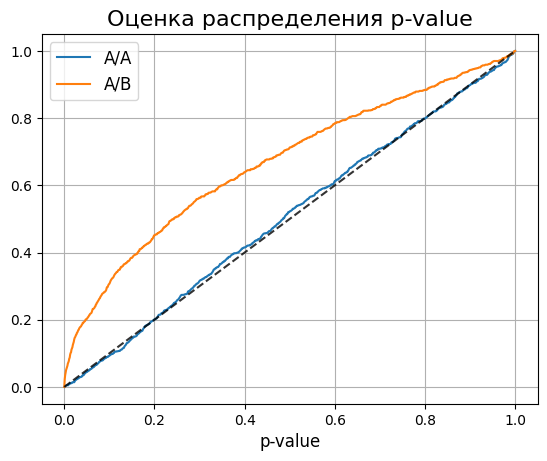

In [ ]:
plot_pvalue_distribution({'A/A': pvalues_aa, 'A/B': pvalues_ab})

Получается, тест работает корректно. Посмотрим также на разниц метрик в наших группах, т.е. разницу рассматриваемых отношений:

In [ ]:
check_delta_method(control_group, test_group)

(5.335168502540455e-06, 0.0960538979788258, 0.07565935529704289)

pvalue говорит нам, что разница статзначима. И действительно, мы видим, что точечная оценка конверсии хорошо подросла, на около 25%!

### Задание 5 (1 балл)

Придумайте пример, в котором тест Манна-Уитни отвергает нулевую гипотезу о равенстве для распределений с равными медианами.

Постройте распределение p-value и изучите долю ошибок первого рода. Объясните, почему получился такой результат. Что тогда проверяет тест Манна-Уитни?

**Ответ**. Рассмотрим равномерные распределения на разных отрезках: например, $U[-500, 500]$ и $U[-1, 1]$. Медиана равномерного распределения $U[a, b]$ равна $\frac{a + b}{2}$, поэтому медианы обоих распределений равны нулю. Более того, у этих распределений равны и средние. Проведем тест Манна-Уитни:

In [ ]:
samples = 1000
alpha = 0.05

pvalues = []
for _ in range(1000):
  test = uniform(loc=-1, scale=2).rvs(samples) # U(loc, scale) = U[loc, loc + scale] => U[-1, 1]
  control = uniform(loc=-500, scale=1000).rvs(samples) # U[-500, 500]

  p_val = mannwhitneyu(control, test, alternative='two-sided').pvalue
  pvalues.append(p_val)

error_rate = np.mean(np.array(pvalues) < alpha)
print(f'Доля ошибок первого рода: {error_rate:0.3f}')

Доля ошибок первого рода: 0.112


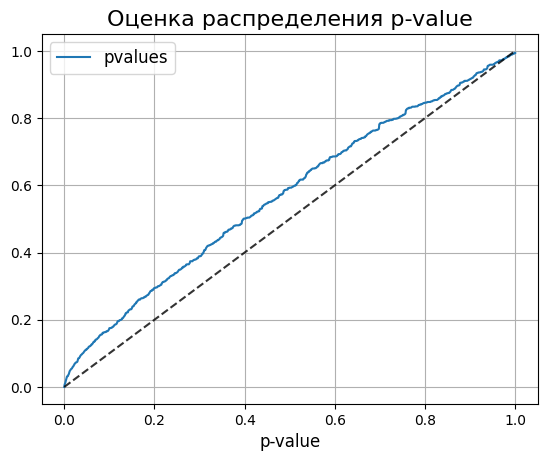

In [ ]:
plot_pvalue_distribution({'pvalues': pvalues})

Как видим, распределение не равномерное. Получается, тест ошибается в практически 11% случаев, а должен был в ~5%. Это происходит, т.к. тест Манна-Уитни проверяет равенство распределений, а не средних или медиан. Тест скорее определяет, насколько слабо совпадают значения между двумя выборками, это ранговый метод, поэтому может только буквально определить, взяты ли данные из одного распределения.

### Задание 6 (1.5 балл)

Вернемся к метрике revenue per user. Вам даны две очень похожие группы (файл `aa_test_logs.pkl`).

1. Постройте распределение p-value для теста на равенство средних между группами.
2. Найдите, на каком уровне искусственно добавленного эффекта средняя выручка в группах станет различима. Ошибку первого рода считайте заданной и равной 0.05. Постройте график зависимости эффекта и ошибки 2 рода.

Для начала обработаем данные:

In [ ]:
aa_test_logs = pd.read_pickle('/content/drive/MyDrive/tpoe/aa_test_logs.pkl')
aa_test_logs.head()

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,DK452H,2023-12-23,first-visited,NaN,NaN,NaN,NaN,NaN
1,ED5SC3,2023-12-19,first-visited,NaN,NaN,NaN,NaN,NaN
2,ED5SC3,2023-12-29,shop-visit,second,npdt49xc6xb1fcbmlh0t,NaN,NaN,NaN
3,GD3FMD,2023-12-02,first-visited,NaN,NaN,NaN,NaN,NaN
4,GD3FMD,2023-12-02,shop-visit,second,kqsakfrjq5ys6kb0s8d0,NaN,NaN,NaN


Сразу удалим лишние записи: ничего, кроме добавлений в корзину и оплат, нам не нужно:

In [ ]:
aa_test_logs = aa_test_logs[aa_test_logs.event.isin(['cart-add', 'cart-paid'])].reset_index(drop=True)

Проверим пересечения групп:

In [ ]:
set(aa_test_logs[aa_test_logs.group == 'first'].user_id) & set(aa_test_logs[aa_test_logs.group == 'second'].user_id)

{'LMHWOC', 'S9ATZM'}

In [ ]:
# получается, можно удалить первую строчку

aa_test_logs[aa_test_logs.user_id == 'LMHWOC']

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
47,LMHWOC,2023-12-01,cart-add,second,85vdm6ue6ca6fl8f06o2,th8cmbdctz,2594.43743,5.0
138,LMHWOC,2023-12-01,cart-add,first,iaffmmz6pk8nd47z8p9j,55j7dfn9aw,1284.50352,1.0
139,LMHWOC,NaT,cart-paid,first,iaffmmz6pk8nd47z8p9j,55j7dfn9aw,NaN,NaN


In [ ]:
aa_test_logs = aa_test_logs.drop(47)

In [ ]:
# а тут был в разных группах в разные покупки, лучше просто удалим

aa_test_logs[aa_test_logs.user_id == 'S9ATZM']

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
74,S9ATZM,2023-12-26,cart-add,first,5uq3g3zg5xfgctwyg5wt,x65lbjrm4c,6711.220669,3.0
75,S9ATZM,NaT,cart-paid,first,5uq3g3zg5xfgctwyg5wt,x65lbjrm4c,NaN,NaN
135,S9ATZM,2023-12-15,cart-add,second,952c7otvx9uytw538vg7,1ur1gdokaf,904.850795,3.0
136,S9ATZM,NaT,cart-paid,second,952c7otvx9uytw538vg7,1ur1gdokaf,NaN,NaN


In [ ]:
aa_test_logs = aa_test_logs.drop([74, 75, 135, 136])

In [ ]:
purchases = aa_test_logs.groupby('cart_id')['event'].apply(lambda x: 'cart-paid' in x.values)
users = pd.merge(purchases, aa_test_logs[['user_id', 'group', 'cart_id']], on='cart_id')

costs = aa_test_logs.groupby('cart_id').amount.max()
users_purchases = pd.merge(users, costs, on='cart_id')
users_purchases = users_purchases.loc[users_purchases.event == True]

del users_purchases['event']
users_purchases = users_purchases[['user_id', 'group', 'amount']].drop_duplicates()

users_only = users_purchases[['user_id', 'group']].drop_duplicates()
total_amount = users_purchases.groupby('user_id').amount.sum()
users_purchases = pd.merge(users_only, total_amount, on='user_id')

In [525]:
first_group = users_purchases[users_purchases.group == 'first'].amount
second_group = users_purchases[users_purchases.group == 'second'].amount

Т.к. теперь у нас выручка по пользователям, данные снова независимые, счастливо возвращаемся к обычным простым тестам:

(array([1353., 1166., 1064., 1030.,  929.,  937.,  868.,  895.,  879.,
         879.]),
 array([2.46500059e-04, 1.00216063e-01, 2.00185626e-01, 3.00155190e-01,
        4.00124753e-01, 5.00094316e-01, 6.00063879e-01, 7.00033442e-01,
        8.00003006e-01, 8.99972569e-01, 9.99942132e-01]),
 <BarContainer object of 10 artists>)

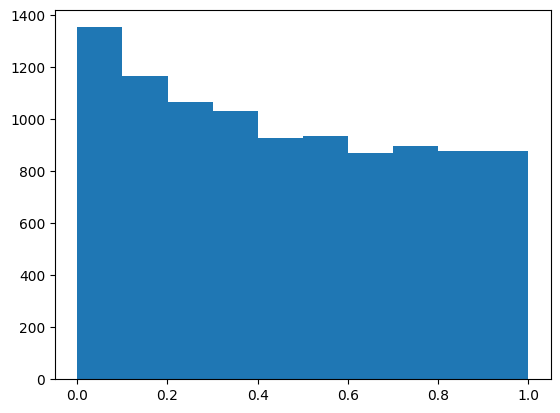

In [ ]:
p_values = []
for _ in range(10000):
  first_s = np.random.choice(first_group, 20, replace=True)
  second_s = np.random.choice(second_group, 20, replace=True)
  pval = ttest_ind(first_s, second_s, alternative='two-sided').pvalue
  p_values.append(pval)

plt.hist(p_values)

In [527]:
kstest(p_values, 'uniform').pvalue < 0.1

True

Как и писали в чате (заметила после нескольких часов непонимания жизни...), данные неидеальные и даже можно взять свои, поэтому довольствуемся таким распределением (т.к. группы должны были быть похоже, распределение должно было быть близким к равномерному: ну в целом похоже, к тому же тест говорит, что равномерно). Сделаем второе задание:

>2) Найдите, на каком уровне искусственно добавленного эффекта средняя выручка в группах станет различима. Ошибку первого рода считайте заданной и равной 0.05. Постройте график зависимости эффекта и ошибки 2 рода.

Проверим, что пока наш результат далек от статзначимости:

In [ ]:
ttest_ind(first_group, second_group).pvalue

0.5102503700513912

Для начала подумаем, какой мы бы хотели получить результат. Ошибка второго рода - принять неверную нулевую гипотезу. В нашем случае нулевая гипотеза: выборки имеют одинаковое среднее, даже при добавлении эффекта к одной из выборок. Ошибка второго рода - сказать, что средние похожи, а на самом деле нет. Если эффект большой, то выборки отличаются сильно, и у нас меньше вероятность не заметить, что группы отличаются. Поэтому ожидаем, что с увеличением эффекта ошибка второго рода будет снижаться. Теперь проверим.




Минимальный эффект для статзначимости: 625.0791666666668


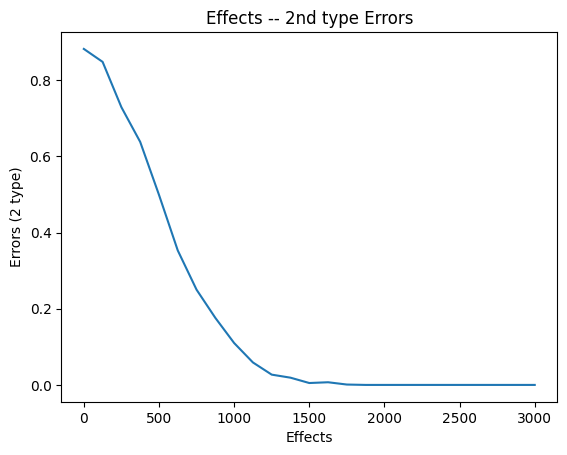

In [ ]:
effects = np.linspace(0.1, 3000, 25)
effect_min = np.infty
errors = []

for effect in effects:
    p_values = []
    for _ in range(1000):
        first_s = np.random.choice(first_group, len(first_group), True)
        second_s =  np.random.choice(second_group, len(second_group), True)
        second_s += effect

        p_value = ttest_ind(first_s, second_s, alternative='two-sided').pvalue
        p_values.append(p_value)

    pvalue_full = ttest_ind(first_group, second_group + effect, alternative='two-sided').pvalue
    if pvalue_full < 0.05:
      effect_min = min(effect_min, effect)

    errors.append(1 - np.mean(np.array(p_values) < 0.05))

print('Минимальный эффект для статзначимости:', effect_min)

plt.plot(effects, errors)
plt.xlabel("Effects")
plt.ylabel("Errors (2 type)")
plt.title("Effects -- 2nd type Errors")
plt.show()

### Задание 7 (1.5 балл)

На метрике revenue per user для разных групп (файл `ab_test_logs.pkl`) посчитайте мощность t-теста, бутстрапа и критерия Манна-Уитни при разных ошибках первого рода. Постройте график зависимости мощности от О1Р.

Какой тест получился мощнее остальных на уровне значимости 5%?

У меня хранится результат с revenue per user в табличке ```users_revenue```.

In [ ]:
test = users_revenue[users_revenue.group == 'test'].amount
control = users_revenue[users_revenue.group == 'control'].amount

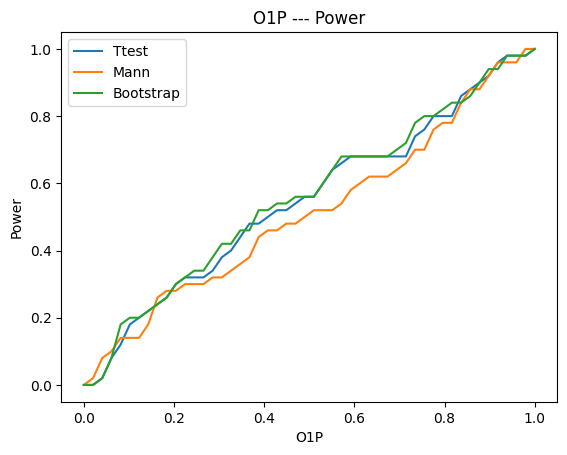

In [ ]:
alphas = np.linspace(0, 1, 50)

power_ttest = np.array([0 for _ in range(50)])
power_mann = np.array([0 for _ in range(50)])
power_bootstrap = np.array([0 for _ in range(50)])

test_size = len(test)
control_size = len(control)
times = 50

for _ in range(times):
    control_sub = np.random.choice(control, control_size, replace=True)
    test_sub = np.random.choice(test, test_size, replace=True)

    power_ttest += np.array([(ttest_ind(control_sub, test_sub).pvalue < alpha) for alpha in alphas])
    power_mann += np.array([(mannwhitneyu(control_sub, test_sub).pvalue < alpha) for alpha in alphas])

    bootstrap_stats = []
    bootstrap_iters = 1000
    for _ in range(bootstrap_iters):
      boot_control = np.random.choice(control_sub, len(control_sub), replace=True)
      boot_test = np.random.choice(test_sub, len(test_sub), replace=True)

      stat = np.mean(boot_control) - np.mean(boot_test)
      bootstrap_stats.append(stat)

    power_bootstrap += np.array([1 - int(np.quantile(bootstrap_stats, alpha / 2) < 0
                                         < np.quantile(bootstrap_stats, 1 - alpha / 2)) for alpha in alphas])

plt.plot(alphas, power_ttest / times, label='Ttest')
plt.plot(alphas, power_mann / times, label="Mann")
plt.plot(alphas, power_bootstrap / times, label='Bootstrap')

plt.xlabel("O1P")
plt.ylabel("Power")
plt.title("O1P -- Power")

plt.legend()
plt.show()

Проверим на ```alpha = 0.05```:

In [ ]:
power_ttest = 0
power_mann = 0
power_bootstrap = 0

test_size = len(test)
control_size = len(control)
times = 50

for _ in range(times):
    control_sub = np.random.choice(control, control_size, replace=True)
    test_sub = np.random.choice(test, test_size, replace=True)

    power_ttest += (ttest_ind(control_sub, test_sub).pvalue < 0.05)
    power_mann += (mannwhitneyu(control_sub, test_sub).pvalue < 0.05)

    bootstrap_stats = []
    bootstrap_iters = 1000
    for _ in range(bootstrap_iters):
      boot_control = np.random.choice(control_sub, len(control_sub), replace=True)
      boot_test = np.random.choice(test_sub, len(test_sub), replace=True)

      stat = np.mean(boot_control) - np.mean(boot_test)
      bootstrap_stats.append(stat)

    power_bootstrap += (1 - int(np.quantile(bootstrap_stats, 0.05 / 2) < 0
                                         < np.quantile(bootstrap_stats, 1 - 0.05 / 2)))

print(power_ttest, power_mann, power_bootstrap)

8 4 9


Мощнее всех получился бутстрап на уровне 0.05, но для более устойчивой оценки нужно повторить эксперимент несколько раз.

### Задание 8 (2 балла)

На данных `aa_test_logs.pkl` реализуйте А/А тесты через бутстрап и постройте распределение p-value. Какое распределение у вас получилось? Почему? Попробуйте доказать этот факт

**Ответ**. Получилось равномерное распределение! действительно, при корректном тестировании A/A-тест дает равномерное распределение pvalues, ведь p-value показывает вероятность получить такое же или большее значение статистики при справедливости нулевой гипотезы!

Просто так посмотрим, что разницы средних распределены нормально (интуитивно понятно из ЦПТ):

<Axes: ylabel='Count'>

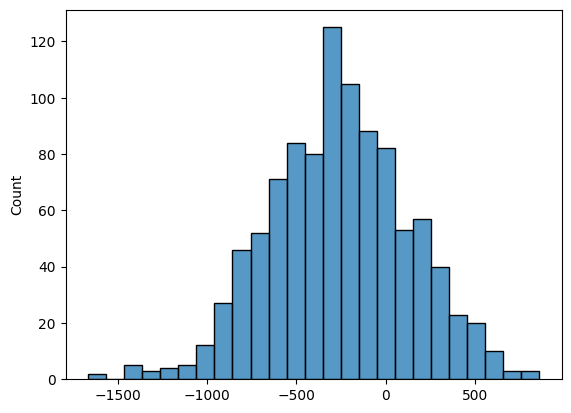

In [ ]:
boot_iters = 1000
stats = []
for _ in range(boot_iters):
    first = np.random.choice(first_group, len(first_group), True)
    second =  np.random.choice(second_group, len(second_group), True)
    stats.append(np.mean(first) - np.mean(second))

stats = np.array(stats)
sns.histplot(stats)

Перейдем к pvalues. Покажу двумя способами: сначала буду усреднять pvalues через бутстрап, а потом буду использовать бутстрап в качестве теста.

<Axes: ylabel='Count'>

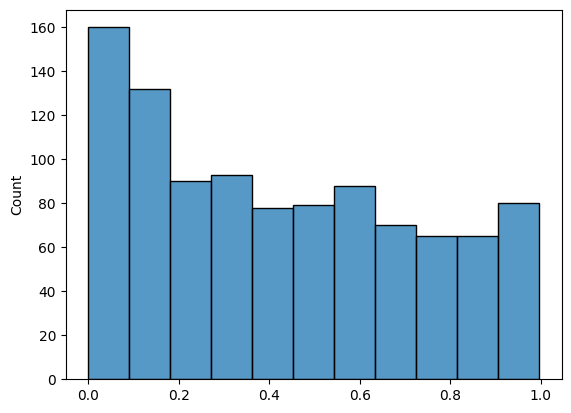

In [522]:
bootstrap_iters = 1000

bootstrap_pvalues = []
for _ in range(bootstrap_iters):
  first = np.random.choice(first_group, len(first_group), True)
  second =  np.random.choice(second_group, len(second_group), True)
  p_value = ttest_ind(first, second, alternative='two-sided').pvalue
  bootstrap_pvalues.append(p_value)

sns.histplot(bootstrap_pvalues)

Проверим тестом:

In [523]:
from scipy.stats import kstest

kstest(bootstrap_pvalues, 'uniform').pvalue < 0.1

True

Сделаем еще одним способом:

<Axes: ylabel='Count'>

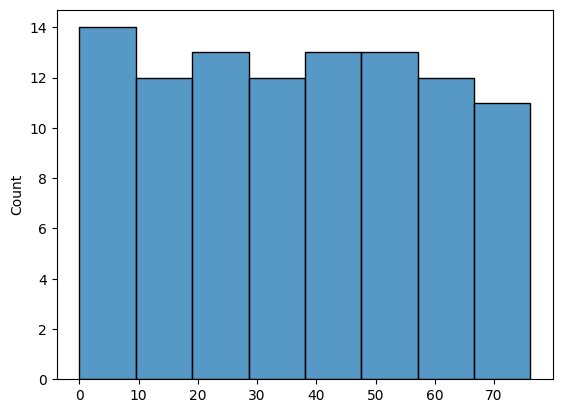

In [495]:
bootstrap_iters = 1000

stat_given = np.mean(first_group) - np.mean(second_group)
pvalues_bootstrap = []
for i in range(100):
  bootstrap_stats = []
  for _ in range(bootstrap_iters):
    first = np.random.choice(first_group, len(first_group), True)
    second =  np.random.choice(second_group, len(second_group), True)
    stat = np.mean(first) - np.mean(second)
    bootstrap_stats.append(stat)

  pvalue = 2 * np.mean(np.abs(np.array(bootstrap_stats)) >= np.abs(stat_given))
  pvalues_bootstrap.append(pvalue)

sns.histplot(pvalues_bootstrap)

In [524]:
from scipy.stats import kstest

kstest(pvalues_bootstrap, 'uniform').pvalue < 0.1

True

Учитывая неидеальность данных, вполне себе равномерно! К тому же тест с нами согласен.

In [ ]:
# смотрю еще немного по-другому, ну почему бы и нет...

ecdf_b = ecdf(stats).cdf

bootstrap_iters = 1000
total_pvalues = np.array([0.0 for _ in range(bootstrap_iters)])

for _ in range(100):
  p_values = []
  for _ in range(bootstrap_iters):
    first = np.random.choice(first_group, len(first_group), True)
    second =  np.random.choice(second_group, len(second_group), True)
    stat = np.mean(first) - np.mean(second)

    # проверяем нахождение в хвостах по бокам
    p_values.append(float(ecdf_b.evaluate(-np.abs(stat))) + (1 - ecdf_b.evaluate(np.abs(stat))))
  total_pvalues += np.array(p_values)

total_pvalues = np.array(total_pvalues) / 100

<Axes: ylabel='Count'>

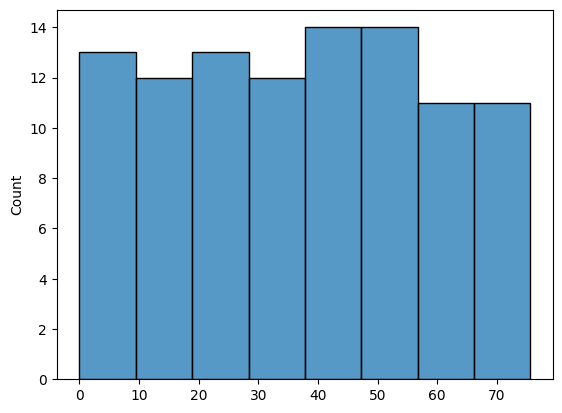

In [514]:
sns.histplot(total_pvalues)